In [1]:
import numpy as np
from itertools import product

from qiskit import Aer, AncillaRegister, ClassicalRegister, execute, QuantumRegister, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.extensions import RYGate, XGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram

from banded_circulant_matrix import block_encoding
from non_hermitian_matrix import dilation

In [2]:
def subspace_sv(num_qubits, num_aux_qubits, sv):
    row_vec = np.zeros(2 ** num_qubits)
    keys = ["".join(k) for k in product("01", repeat=num_qubits)]
    
    for j, key in enumerate(keys):
        idx = int(key + "0" * num_aux_qubits, 2)
        row_vec[j] = np.real(sv[idx])
    
    return row_vec

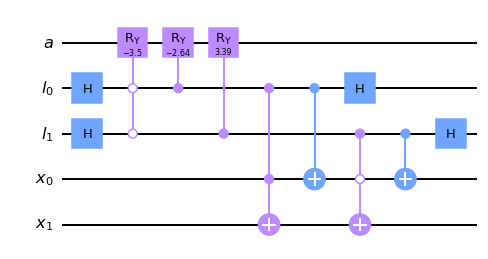

In [3]:
alpha = 0.75
beta = 0.25
gamma = - 0.125

num_sys_qubits = 2
u = block_encoding(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
u.draw("mpl", fold=-1)

In [4]:
num_aux_qubits = 3

for i in range(2 ** num_sys_qubits):
    qc = block_encoding(alpha, beta, gamma, num_sys_qubits, i=i, j=0, add_measurements=False)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 0.1875   0.0625   0.      -0.03125]
[-0.03125  0.1875   0.0625   0.     ]
[ 0.      -0.03125  0.1875   0.0625 ]
[ 0.0625   0.      -0.03125  0.1875 ]


## Dilation of non-Hermitian matrix

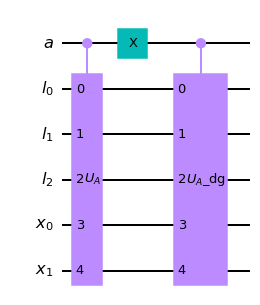

In [5]:
num_aux_qubits = u.num_ancillas

# initialise quantum registers
qa = AncillaRegister(size=1, name="a")
ql = AncillaRegister(size=num_aux_qubits, name="l")

# qubits representing |b> and solution |x>
qx = QuantumRegister(size=num_sys_qubits, name="x")

qc = QuantumCircuit(qa, ql, qx, name="$U_A$")

u_gate = u.to_gate()
qc.append(u_gate.control(1, ctrl_state="1"), qa[:] + ql[:] + qx[:])
qc.x(qa)
qc.append(u_gate.inverse().control(1, ctrl_state="1"), qa[:] + ql[:] + qx[:])

qc.draw("mpl", fold=-1)

Changing the order of qubits to [`ql`, `qx`, `qa`]

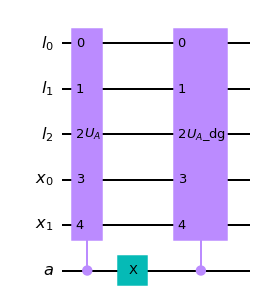

In [6]:
expanded_u = dilation(u)
expanded_u.draw("mpl", fold=-1)

In [7]:
num_aux_qubits = 3
num_sys_qubits = 2 + 1

for i in range(2 ** num_sys_qubits):
    qc = dilation(u, i=i, j=0, add_measurements=False)
    print(subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.87500000e-01 -3.12500000e-02 -3.39825199e-17  6.25000000e-02]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.25000000e-02  1.87500000e-01 -3.12500000e-02 -8.60799627e-18]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.38671961e-17  6.25000000e-02  1.87500000e-01 -3.12500000e-02]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.12500000e-02  8.49267249e-18  6.25000000e-02  1.87500000e-01]
[ 1.87500000e-01  6.25000000e-02  7.65084349e-18 -3.12500000e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[-3.12500000e-02  1.87500000e-01  6.25000000e-02 -2.01047321e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 8.49267249e-18 -3.12500000e-02  1.87500000e-01  6.25000000e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 6.25000000e-02  3.63252603e-19 -3.12500000e-02  1.87500000e-01
  0.00000000e+00  

We can see that
\begin{equation}
\tilde{A} = 
\begin{bmatrix}
0 & A^{\dagger} \\
A & 0
\end{bmatrix}
\end{equation}